In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree


### 获取数据

In [9]:
new_data = pd.read_csv('../data/new_data.csv')

In [10]:
new_data = new_data.drop('Unnamed: 0', axis=1)

In [11]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   value                 75552 non-null  float64
 1   weather_status        75552 non-null  float64
 2   temperature           75552 non-null  float64
 3   humidity              75552 non-null  float64
 4   wind_speed            75552 non-null  float64
 5   wind_direction_angle  75552 non-null  float64
 6   pressure              75552 non-null  float64
 7   visibility            75552 non-null  float64
 8   precipitation         75552 non-null  float64
 9   light                 75552 non-null  float64
 10  holiday               75552 non-null  float64
 11  minute                75552 non-null  float64
 12  week                  75552 non-null  float64
 13  year                  75552 non-null  float64
dtypes: float64(14)
memory usage: 8.1 MB


In [12]:
new_data = new_data.astype(np.float32)

In [13]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   value                 75552 non-null  float32
 1   weather_status        75552 non-null  float32
 2   temperature           75552 non-null  float32
 3   humidity              75552 non-null  float32
 4   wind_speed            75552 non-null  float32
 5   wind_direction_angle  75552 non-null  float32
 6   pressure              75552 non-null  float32
 7   visibility            75552 non-null  float32
 8   precipitation         75552 non-null  float32
 9   light                 75552 non-null  float32
 10  holiday               75552 non-null  float32
 11  minute                75552 non-null  float32
 12  week                  75552 non-null  float32
 13  year                  75552 non-null  float32
dtypes: float32(14)
memory usage: 4.0 MB


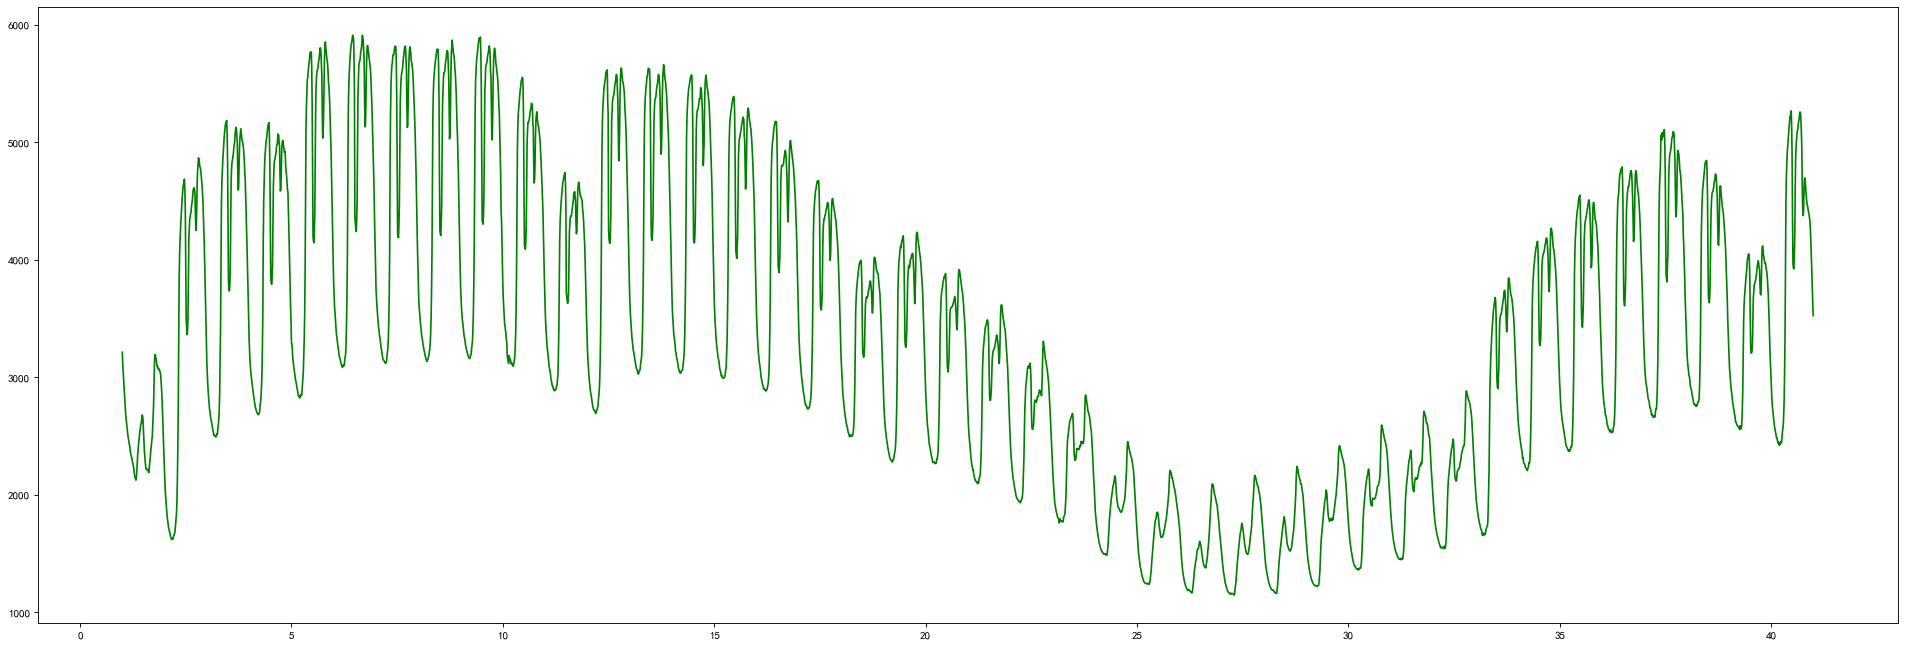

In [14]:
# 2021-1-1到2021-2-9
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, 41, 96*40, endpoint=True)
plt.plot(X, np.array(new_data['value'])[: 96*40], color='green')
plt.show()

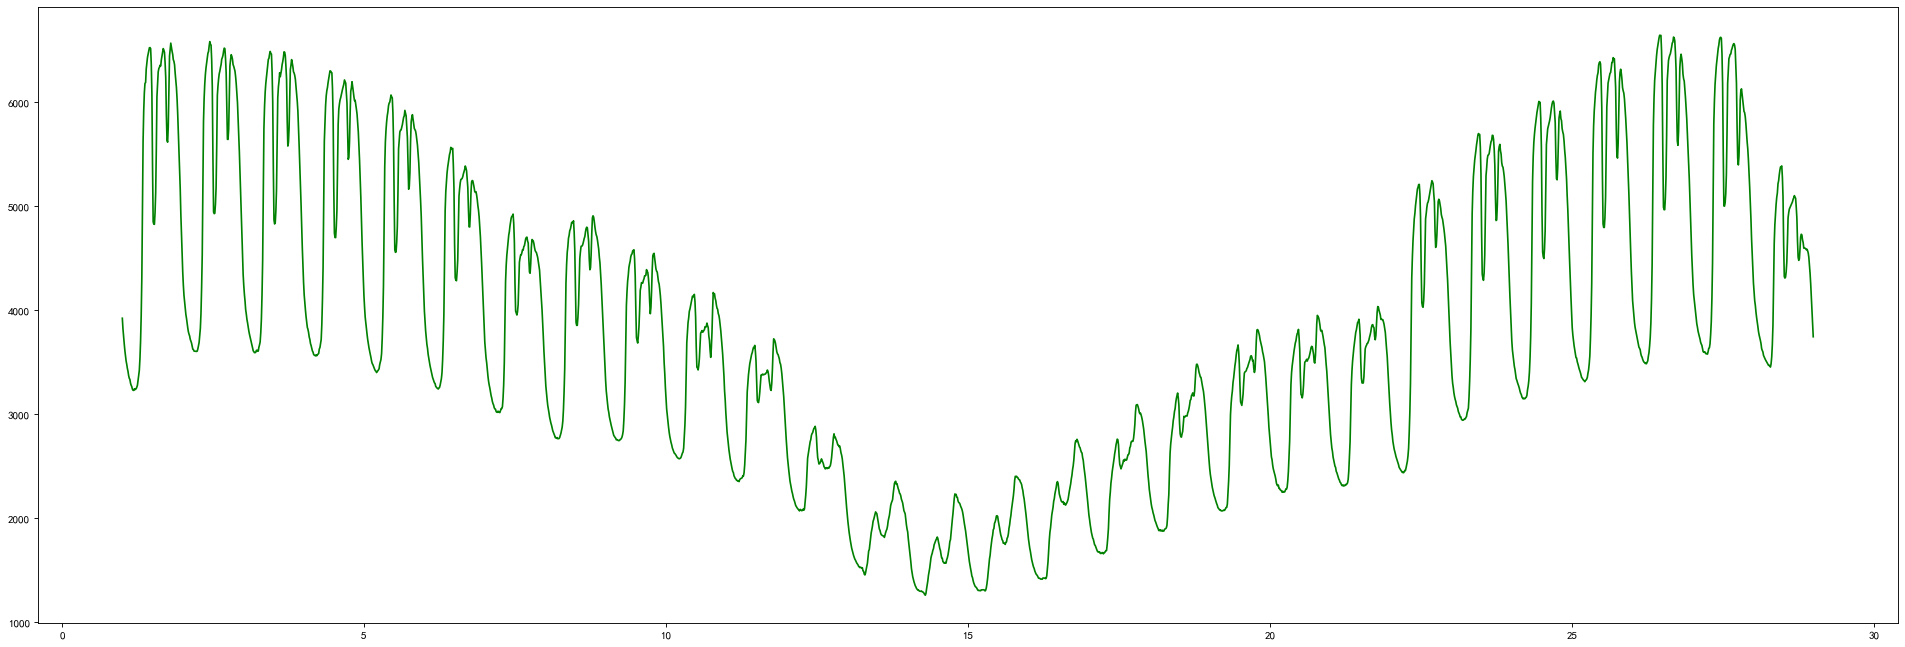

In [15]:
# 2022-2-1到2022-2-28
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, 29, 96*28, endpoint=True)
plt.plot(X, np.array(new_data['value'])[38016: 38016+96*28], color='green')
plt.show()

数据总长度：70560，切片范围：[67488, 70560)
y_slice 长度：3072


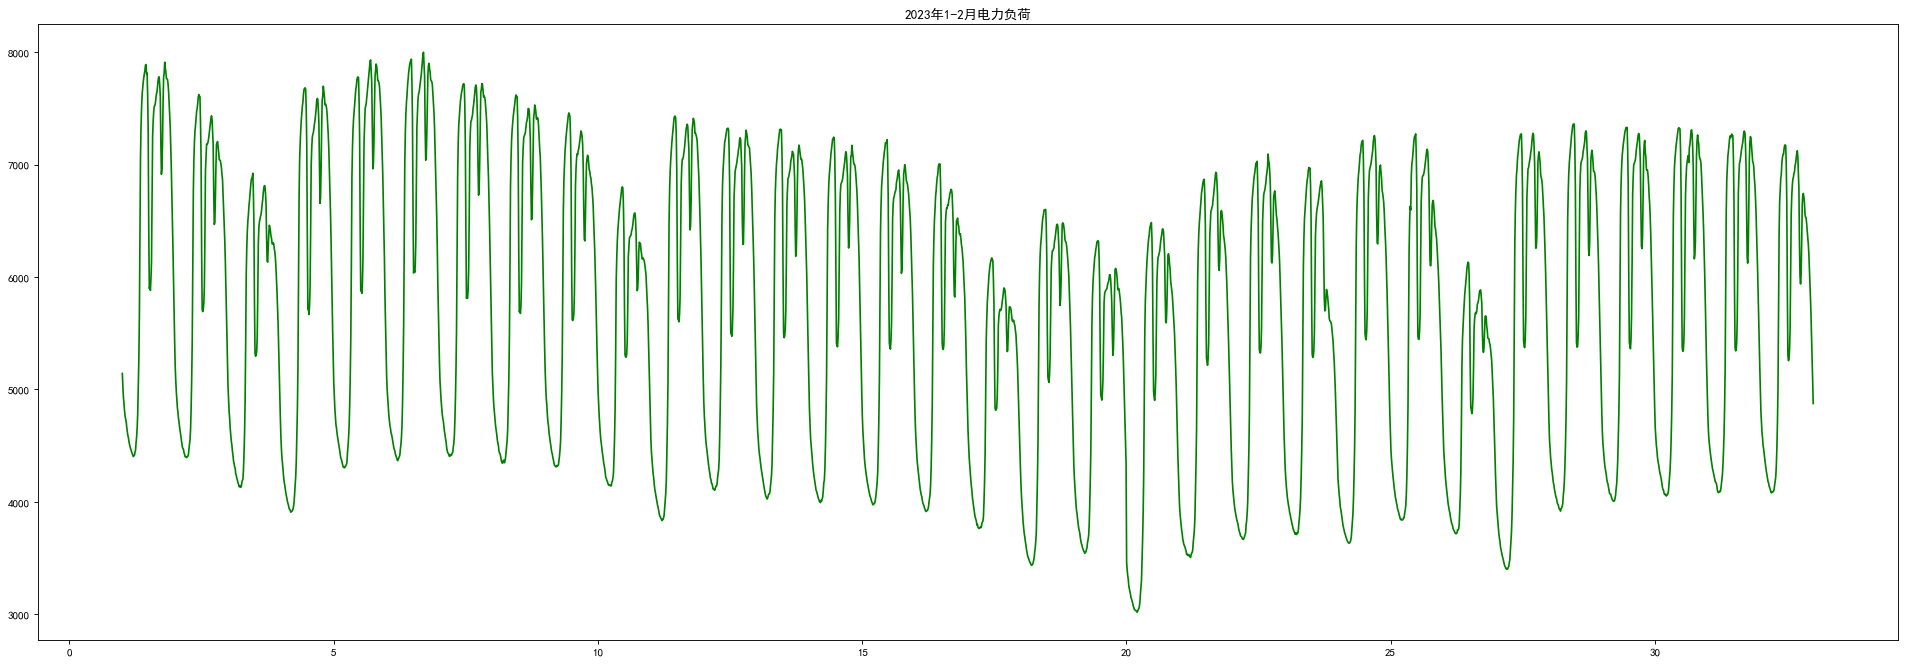

In [61]:
# # 2023-1-20到2023-2-20
# plt.figure(figsize=(30, 10), dpi=80)

# X = np.linspace(1, 33, 96*32, endpoint=True)
# plt.plot(X, np.array(new_data['value'])[71904: 71904+96*32], color='green')
# plt.show()
# 2023年1-2月数据（假设从数据末尾往前推32天）
days = 32
points_per_day = 96
start_idx = max(0, len(new_data['value']) - days * points_per_day)  # 从末尾倒推
end_idx = len(new_data['value'])  # 到数据末尾

# 验证切片范围
print(f"数据总长度：{len(new_data['value'])}，切片范围：[{start_idx}, {end_idx})")

# 执行切片
y_slice = np.array(new_data['value'])[start_idx:end_idx]
print(f"y_slice 长度：{len(y_slice)}")

# 动态生成 X 轴（与 y 长度匹配）
X = np.linspace(1, days + 1, len(y_slice), endpoint=True)  # 从1到33天

# 绘图
if len(y_slice) > 0:
    plt.figure(figsize=(30, 10), dpi=80)
    plt.plot(X, y_slice, color='green')
    plt.title('2023年1-2月电力负荷')
    plt.show()
else:
    print("错误：切片结果为空，请检查索引范围！")

2021年、2022年、2023年年初电力负荷均出现了明显的先下降后上升过程，但原因不明，需要和电力公司沟通，了解原因。因此在模型训练和测试时选择将这段时间的数据忽略。

删去2021-1-21到2021-2-6，2022-2-9到2022-2-24，2023-1-26到2023-2-13的数据

In [17]:
drop_index = [i for i in range(1920, 3552)] + [i for i in range(38784, 40320)] + [i for i in range(72480, 74304)]

In [18]:
new_data = new_data.drop(drop_index, axis=0)

In [19]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70560 entries, 0 to 75551
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   value                 70560 non-null  float32
 1   weather_status        70560 non-null  float32
 2   temperature           70560 non-null  float32
 3   humidity              70560 non-null  float32
 4   wind_speed            70560 non-null  float32
 5   wind_direction_angle  70560 non-null  float32
 6   pressure              70560 non-null  float32
 7   visibility            70560 non-null  float32
 8   precipitation         70560 non-null  float32
 9   light                 70560 non-null  float32
 10  holiday               70560 non-null  float32
 11  minute                70560 non-null  float32
 12  week                  70560 non-null  float32
 13  year                  70560 non-null  float32
dtypes: float32(14)
memory usage: 4.3 MB


**所有数据用于决策树的训练**

In [20]:
Xtrain = np.array(new_data.drop('value', axis=1))
Ytrain = np.array(new_data['value'])

In [21]:
clf1 = tree.DecisionTreeRegressor(criterion="squared_error")
clf2 = tree.DecisionTreeRegressor(criterion="squared_error")

In [22]:
clf1 = clf1.fit(Xtrain, Ytrain)
clf2 = clf2.fit(Xtrain, Ytrain)

In [23]:
clf1.score(Xtrain, Ytrain)

1.0

In [24]:
clf2.score(Xtrain, Ytrain)

1.0

In [25]:
#clf.feature_importances_

In [26]:
feature_name = ['weather_status', 'temperature', 'humidity(湿度)', 'wind_speed', 'wind_direction_angle', 'pressure', 'visibility(可见度)', 'precipitation(降水)',
                'light', 'holiday', 'minute', 'week', 'year']

In [27]:
pd.DataFrame(zip(feature_name, clf1.feature_importances_)).set_index(0).sort_values(by=1, ascending=False)

,1
0,
minute,0.519743
temperature,0.160394
week,0.074406
humidity(湿度),0.054390
year,0.052506
holiday,0.042241
visibility(可见度),0.030242
pressure,0.026985
light,0.012418


In [28]:
pd.DataFrame(zip(feature_name, clf2.feature_importances_)).set_index(0).sort_values(by=1, ascending=False)

,1
0,
minute,0.520141
temperature,0.159917
week,0.074446
humidity(湿度),0.054727
year,0.052573
holiday,0.042247
visibility(可见度),0.029840
pressure,0.027440
light,0.012741


**2021年和2022年的数据作为训练集，2023年的数据作为测试集**

In [29]:
train = new_data.loc[:70079]
test = new_data.loc[70080:]

In [30]:
Xtrain = np.array(train.drop('value', axis=1))
Ytrain = np.array(train['value'])
Xtest = np.array(test.drop('value', axis=1))
Ytest = np.array(test['value'])

In [31]:
print(len(train))
print(len(test))

66912
3648


In [32]:
3648/96

38.0

In [33]:
clf3 = tree.DecisionTreeRegressor(criterion="squared_error")
clf3 = clf3.fit(Xtrain, Ytrain)

In [34]:
pd.DataFrame(zip(feature_name, clf3.feature_importances_)).set_index(0).sort_values(by=1, ascending=False)

,1
0,
minute,0.511706
temperature,0.165325
week,0.077187
humidity(湿度),0.055416
year,0.051855
holiday,0.041554
visibility(可见度),0.030861
pressure,0.026587
light,0.012538


In [35]:
clf3.score(Xtest, Ytest)

0.6929981087328428

In [36]:
pred = clf3.predict(Xtest)
pred

array([2395.90625   , 2395.90625   , 2395.90625   , ..., 5394.65869141,
       5310.05908203, 5270.03369141])

In [37]:
APE = abs(pred - Ytest) / Ytest

In [38]:
# MAPE
sum(APE) / len(APE)

0.10809588530369675

In [39]:
min(APE), max(APE)

(4.330354347397385e-06, 1.061837995491007)

<Axes: >

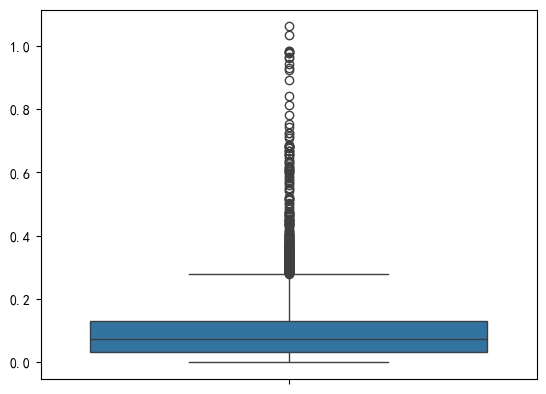

In [40]:
sns.boxplot(data=APE)

(0.0, 0.4)

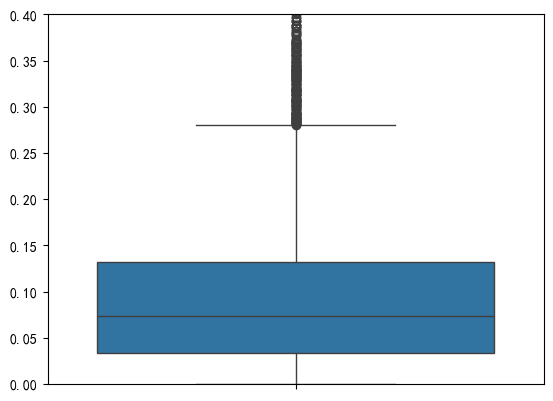

In [41]:
sns.boxplot(data=APE)
plt.ylim(0, 0.4)

**2021年、2022年前11个月和2023年的数据作为训练集，2022年12月的数据作为测试集(作为与其他模型性能的对比)**

In [42]:
new_data = new_data.drop(['light', 'wind_speed', 'wind_direction_angle', 'weather_status', 'precipitation'], axis=1)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70560 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        70560 non-null  float32
 1   temperature  70560 non-null  float32
 2   humidity     70560 non-null  float32
 3   pressure     70560 non-null  float32
 4   visibility   70560 non-null  float32
 5   holiday      70560 non-null  float32
 6   minute       70560 non-null  float32
 7   week         70560 non-null  float32
 8   year         70560 non-null  float32
dtypes: float32(9)
memory usage: 5.0 MB


In [43]:
train = pd.concat([new_data.loc[:67103], new_data.loc[70080:]], axis=0)
test = new_data.loc[67104:70079]

In [44]:
Xtrain = np.array(train.drop('value', axis=1))
Ytrain = np.array(train['value'])
Xtest = np.array(test.drop('value', axis=1))
Ytest = np.array(test['value'])

In [45]:
clf4 = tree.DecisionTreeRegressor(criterion="squared_error")
clf4 = clf4.fit(Xtrain, Ytrain)

In [46]:
feature_name = ['temperature', 'humidity', 'pressure', 'visibility', 'holiday', 'minute', 'week', 'year']

In [47]:
pd.DataFrame(zip(feature_name, clf4.feature_importances_)).set_index(0).sort_values(by=1, ascending=False)

,1
0,
minute,0.520055
temperature,0.173994
week,0.077940
humidity,0.060878
year,0.051613
holiday,0.041522
visibility,0.037336
pressure,0.036662


In [48]:
clf4.score(Xtest, Ytest)

0.6830727616747405

In [49]:
pred = clf4.predict(Xtest)

In [50]:
APE = abs(pred - Ytest) / Ytest

In [51]:
# 保存列表
np.save('tree_mape', APE)

In [52]:
# MAPE
sum(APE) / len(APE) 

0.09167217789350864

<Axes: >

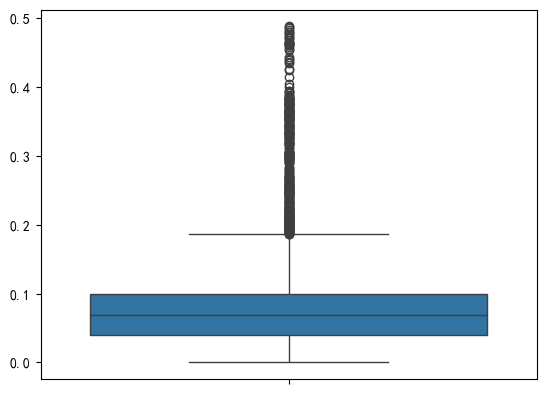

In [53]:
sns.boxplot(data=APE)

(0.0, 0.2)

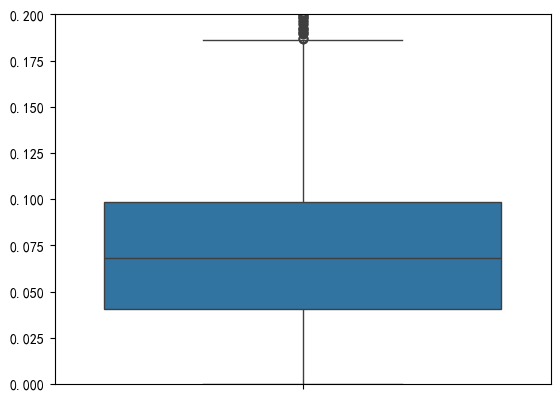

In [54]:
sns.boxplot(data=APE)
plt.ylim(0, 0.2)

In [55]:
max(APE), min(APE)

(0.4876765938535674, 0.00010957837313336104)

根据上图的特征重要性，神经网络模型训练时，删去light、wind_speed、wind_direction_angle、weather_status、precipitation这5个特征。

年份的重要性在0.052左右，是一个不可忽视的因素。由于数据集只有2021年、2022年和2023年前2个月的数据，若模型用2021和2022年的数据训练，预测2023年2个月
的负荷，则模型对年份特征的掌握情况还不够好，我期望的是有过去3年以上的数据来预测下一年的负荷。因此，模型使用2021年、2022年前11个月、2023年的数据训练，
预测2022年12月的负荷。